本节我们利用卷积神经网络来识别手写数字，我们把原来28 × 28的图像经过两次卷积运算转换为36张7 × 7的图像，然后reshape为36 × 7 × 7 = 1764维向量作为平坦层的输入，隐藏层设置128个神经元，输出层设置10个神经元，对应数字0-9

# 数据预处理

用下列代码读取MNIST数据集

In [1]:
import tensorflow as tf
import tensorflow.examples.tutorials.mnist.input_data as input_data
mnist = input_data.read_data_sets('MNIST_data/', one_hot = True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.


URLError: <urlopen error [WinError 10060] 由于连接方在一段时间后没有正确答复或连接的主机没有反应，连接尝试失败。>

# 建立共享函数

为了便于后续建立模型，我们建立下面的共享函数

定义weight函数，用于建立权重张量。输入参数shape，先以tf.truncated_normal随机方式初始化权重，然后用tf.Variable建立Tensorflow变量

In [2]:
def weight(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1), name='W')

定义bias函数，用于建立偏差张量。输入参数shape，先以tf.constant建立常数（输入参数：0.1与shape），然后建立Tensorflow变量（tf.Variable），并返回计算结果

In [3]:
def bias(shape):
    return tf.Variable(tf.constant(0.1, shape=shape), name = 'b')

定义conv2d函数，进行卷积运算。效果相当于滤镜的功能

In [4]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

$\bullet$**x是输入图像：** 后续我们传入需要处理的图像，必须是四维的张量

$\bullet$**W是filter weight滤镜的权重：** 后续我们以随机方式产生filter weight并传递给此参数

$\bullet$**stride：** 滤镜的步长，设置为[1, 1, 1, 1]，格式是[1, stride, stride, 1]，也就是让滤镜每一次移动时候，从左到右，从上到下各一步。

$\bullet$**padding:** 设置为'SAME'模式，此模式会在边界之外补0，在进行运算时，让输入与输出相同

创建max_pool_2×2函数，用于建立池化层进行图像的缩减采样

In [7]:
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

$\bullet$**x是输入的图像：**  后续我们传入需要处理的图像，必须是四维的张量

$\bullet$**ksize：** 缩减采样窗口大小，设置为[1, 2, 2, 1]，格式为[1, height, width, 1], 也就是高度=2，宽度=2的窗口

$\bullet$**stride:** 缩减采样窗口的跨步，设置为[1, 2, 2, 1]， 格式是[1, stride, stride, 1]，也就是缩减采样窗口，从左到右，从上到下移动时步长各两步

# 建立模型

在下面的程序中，每一个都会加入计算图的层级名称。例如，输入层会加入with tf.name_scope('Input_Layer')，功能是设置输入层的名称为'Input_Layer'。

如果不设置计算图的层级名称，程序仍然可以正常运行，但是因为CNN的层级比较复杂而且层级很多哦，所以设置层级名称可以增加代码的可读性。另外后续我们使用TensorBoard查看计算图时，可以清晰地看到每一个层级，比较容易使用TensorBoard查看计算图

### 建立输入层

In [9]:
with tf.name_scope('Input_Layer'):
    x = tf.placeholder('float', shape=[None, 784], name='x')
    x_image = tf.reshape(x, [-1, 28, 28, 1])

x_image = tf.reshape(x, [-1, 28, 28, 1])将x reshape为四维张量（因为后续要进行卷积和池化运算），说明如下：

$\bullet$**第一维是-1：** 因为后续训练时通过placeholder输入的项数不固定，所以设置为-1

$\bullet$**第二，三维是28,28：** 因为输入数字图像大小是28 × 28

$\bullet$**第四维是1：** 因为是单色，所以设置为1，如果是彩色，则设置为3

### 建立卷积层1 

卷积层会以单个图像来产生多个图像，卷积运算后的效果类似于滤镜效果。这有助于提取输入的不同特征，例如边缘，线条和角等

输入数字图像大小为28 × 28，例如数字7的图像。卷积运算会产生16个图像，卷积运算不会改变图像大小，所以图像大小仍然为28 × 28。我们可以看到这些图像仍然是7，但是提取了不同的特征。

下面建立卷积层1，计算图的层级名称是C1_Conv

In [10]:
with tf.name_scope('C1_Conv'):
    W1 = weight([5, 5, 1, 16])
    b1 = bias([16])
    Conv1 = conv2d(x_image, W1) + b1
    C1_Conv = tf.nn.relu(Conv1)

代码说明

**W1 = weight([5, 5, 1, 16])使用之前建立的共享函数建立W1权重**

$\bullet$**第一，二维均是5：** 代表滤镜大小（filter weight）是5 × 5

$\bullet$**第三维是1：** 因为图像是单色的，所以设置为1，如果是彩色的，设为3

$\bullet$**第四维是16：** 要产生16个图像

**b1 = bias([16])用之前建立的bias函数建立偏差值**

因为卷积层1要产生16个图像，所以要输入参数shape=[16]

**Conv1 = conv2d(x_image, W1) + b1进行卷积运算**

输入参数是：x_image（要处理的图像），W1（滤镜的权重），conv2d进行计算，b1（偏置）

**C1_Conv = tf.nn.relu(Conv1)使用relu函数做激活函数**

### 建立池化层1

池化层使用缩减采样会将图像从28 × 28缩小成14 × 14，不改变图像数量（仍然为16）。

缩减采样会缩小图像，有以下好处：

**（1）减少需要处理的数据点：** 减少后续运算所需要的时间。

**（2）让图像位置差异变小：** 例如手写数字7，位置上下左右可能不同，但是位置不同可能会影响识别，减小图像大小让数字的位置差异变小。

**（3）参数的数量和计算量下降：** 在一定程度上控制了过拟合。

下面使用之前创建的max_pool_2x2函数传入卷积层C1_Conv进行缩减采样。建立池化层1，计算图的层级名称是C1_Pool

In [11]:
with tf.name_scope('C1_Pool'):
    C1_Pool = max_pool_2x2(C1_Conv)

### 建立卷积层2

第2次卷积运算将原本的16个图像转换为36个图像，不改变图像大小，仍为14 × 14。下列代码建立卷积层2，计算图的层级名称是C2_Conv。

In [12]:
with tf.name_scope('C2_Conv'):
    W2 = weight([5, 5, 16, 36])
    b2 = bias([36])
    Conv2 = conv2d(C1_Pool, W2) + b2
    C2_Conv = tf.nn.relu(Conv2)

代码说明

**W2 = weight([5, 5, 16, 36])使用之前建立的共享函数建立W2权重**

$\bullet$**第一，二维均是5：** 代表滤镜大小（filter weight）是5 × 5

$\bullet$**第三维是16：** 因为卷积层的图像数量是16个。

$\bullet$**第四维是36：** 要将原来的16个图像转换为36个图像

**b2 = bias([36])用之前建立的bias函数建立偏差值**

因为卷积层2要产生36个图像，所以要输入参数shape=[36]

**Conv2 = conv2d(C1_Pool, W2) + b2进行卷积运算**

输入参数是：C1_Pool（池化层1），W2（滤镜的权重），conv2d进行计算，b2（偏置）

**C2_Conv = tf.nn.relu(Conv2)使用relu函数做激活函数**

### 建立池化层2

建立池化层2进行缩减采样，层级名称是C2_Pool

In [13]:
with tf.name_scope('C2_Pool'):
    C2_Pool = max_pool_2x2(C2_Conv)

### 建立平坦层

平坦层可以将池化层2的36个7 × 7的图像reshape为一维的向量，长度为36 × 7 × 7 = 1764，也就是1764个浮点数，作为神经网络的输入。用以下的代码建立平坦层。计算图的层级名称为D_Flat。

In [14]:
with tf.name_scope('D_Flat'):
    D_Flat = tf.reshape(C2_Pool, [-1, 1764]) #因为后续会传入不定项的训练数据，所以第一维设置为-1

### 建立隐藏层

下面建立输出层，层级名称为D_Hidden_Layer

In [15]:
with tf.name_scope('D_Hidden_Layer'):
    W3 = weight([1764, 128]) #建立W3权重
    b3 = bias([128]) #建立偏置向量
    D_Hidden = tf.nn.relu(tf.matmul(D_Flat, W3) + b3) #建立隐藏层
    D_Hidden_Dropout = tf.nn.dropout(D_Hidden, keep_prob=0.8) 
    #加入DropOut避免过拟合，第一个参数是要执行dropout的神经网络层，0.8代表保留80%的神经元

### 建立输出层

下面建立输出层，层级名称是Output_Layer

In [17]:
with tf.name_scope('Output_Layer'):
    W4 = weight([128, 10])  
    b4 = bias([10])
    y_predict = tf.nn.softmax(tf.matmul(D_Hidden_Dropout, W4) + b4) #使用softmax做激活函数

# 定义训练方式

定义训练方式与18章完全相同

In [19]:
with tf.name_scope('optimizer'):
    y_label = tf.placeholder('float', shape=[None, 10], name='y_label')
    
    loss_function = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_predict, labels=y_label))
    
    optimizer = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(loss_function)

# 定义评估模型准确率的方式

与18章完全相同

In [20]:
with tf.name_scope('evaluate_model'):
    correct_prediction = tf.equal(tf.argmax(y_predict, 1), tf.argmax(y_label, 1))
    
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))

# 进行训练

### 定义训练参数

In [21]:
trainEpochs = 30 #设置训练周期为30个周期
batchSize = 100 #每一批次的项数是100
totalBatchs = int(mnist.train.images.shape[0] / batchSize) #设置训练批次数
loss_list=[]; epoch_list = []; accuracy_list=[]
#初始化训练周期，误差，准确率。后续每一个训练周期完成之后，会记录误差与准确率，在下一个步骤以图形显示出来
from time import time #导入时间模块
startTime = time() #开始计算时间

sess = tf.Session() #建立Tensorflow Session
sess.run(tf.global_variables_initializer()) #初始化Tensorflow global变量

### 执行训练

In [22]:
for epoch in range(trainEpochs): #执行30个训练周期
    #执行550批次训练，使用优化器进行训练，使误差最小化
    for i in range(totalBatchs): 
        batch_x, batch_y = mnist.train.next_batch(batchSize)
        sess.run(optimizer, feed_dict={x: batch_x, y_label: batch_y})
    #550批次训练完成后，使用验证数据计算此次训练周期后的误差和准确率
    loss, acc = sess.run([loss_function, accuracy],
                         feed_dict={x: mnist.validation.images, y_label: mnist.validation.labels})
    #显示训练结果，并且存入列表
    epoch_list.append(epoch)
    loss_list.append(loss)
    accuracy_list.append(acc)
    print('Train Epoch:', '%02d' %(epoch + 1), 'Loss=', '{:.9f}'.format(loss), 'Accuracy=', acc)
#计算并显示全部运行时间
duration = time() - startTime
print('Train Finished takes:', duration)

Train Epoch: 01 Loss= 1.629643798 Accuracy= 0.851
Train Epoch: 02 Loss= 1.552029133 Accuracy= 0.9214
Train Epoch: 03 Loss= 1.533420682 Accuracy= 0.937
Train Epoch: 04 Loss= 1.518822312 Accuracy= 0.9464
Train Epoch: 05 Loss= 1.511940598 Accuracy= 0.9532
Train Epoch: 06 Loss= 1.504353166 Accuracy= 0.9616
Train Epoch: 07 Loss= 1.499855042 Accuracy= 0.9654
Train Epoch: 08 Loss= 1.495408535 Accuracy= 0.9682
Train Epoch: 09 Loss= 1.491850734 Accuracy= 0.9716
Train Epoch: 10 Loss= 1.490412712 Accuracy= 0.973
Train Epoch: 11 Loss= 1.489847302 Accuracy= 0.9738
Train Epoch: 12 Loss= 1.488437533 Accuracy= 0.976
Train Epoch: 13 Loss= 1.486395955 Accuracy= 0.9764
Train Epoch: 14 Loss= 1.483748198 Accuracy= 0.9802
Train Epoch: 15 Loss= 1.486587524 Accuracy= 0.976
Train Epoch: 16 Loss= 1.482606411 Accuracy= 0.981
Train Epoch: 17 Loss= 1.482578516 Accuracy= 0.9798
Train Epoch: 18 Loss= 1.481892347 Accuracy= 0.9808
Train Epoch: 19 Loss= 1.480373263 Accuracy= 0.9816
Train Epoch: 20 Loss= 1.481218696 Acc

训练结果准确率达到了0.9846

画出误差执行结果图

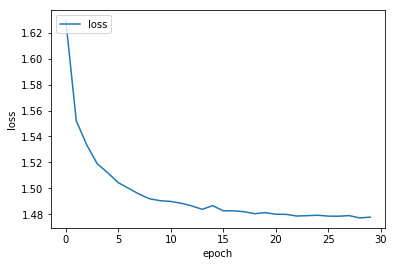

In [24]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(epoch_list, loss_list, label = 'loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss'], loc = 'upper left')

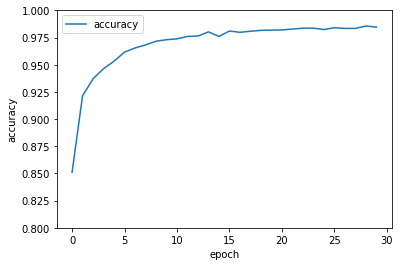

In [26]:
plt.plot(epoch_list, accuracy_list, label = 'accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim(0.8, 1)
plt.legend()

# 评估模型准确率

In [27]:
print('Accuracy:', sess.run(accuracy, feed_dict={x: mnist.test.images, y_label: mnist.test.labels}))

Accuracy: 0.9854


准确率为0.9854

# 进行预测

### 执行预测

In [28]:
predict_result = sess.run(tf.argmax(y_predict, 1), feed_dict={x: mnist.test.images, y_label: mnist.test.labels})

### 查看前10项预测结果

In [29]:
predict_result[: 10]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])

### 显示前10项预测结果

In [30]:
import matplotlib.pyplot as plt
import numpy as np
def plot_images_labels_prediction(images, labels, prediction, idx, num = 10):
#函数的参数分别是images（数字图像），labels（真实值），prediction（预测结果），idx(开始显示的数据index)，num(要显示的数据项数，默认是10.不超过25)
    fig = plt.gcf()
    fig.set_size_inches(12, 14)
    if num > 25: num = 25
    for i in range(0, num):
        #绘制图形
        ax = plt.subplot(5, 5, i + 1)
        ax.imshow(np.reshape(images[idx],(28, 28)), cmap = 'binary')
        title = 'label=' + str(np.argmax(labels[idx]))#设置标题
        if len(prediction)>0:#如果传入了预测结果
            title+= ',predict=' + str(prediction[idx])#标题
        
        ax.set_title(title, fontsize = 10)#设置子图形标题
        ax.set_xticks([]);ax.set_yticks([])#设置不显示刻度
        idx+=1#读取下一项
    plt.show()

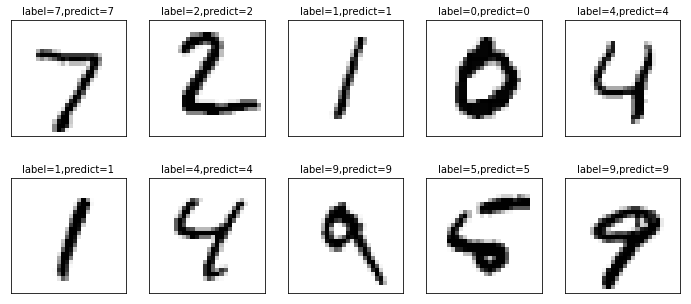

In [31]:
plot_images_labels_prediction(mnist.test.images, mnist.test.labels, predict_result, 0)

# TensorBoard

将要显示在TensorBoard的计算图写入log文件

In [32]:
megred = tf.summary.merge_all()
train_writer = tf.summary.FileWriter('log/CNN', sess.graph)